# XGBoost

In [ ]:
!pip install xgboost
!pip install hyperopt
!pip install statsmodels
!pip install openpyxl

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, tpe, fmin

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV , RandomizedSearchCV, cross_val_predict

from warnings import filterwarnings
filterwarnings('ignore')

sns.set()

In [ ]:
df = pd.read_excel('/work/Data Modelos.xlsx')
df.columns

Index(['Suscriptores ganados', 'Tiempo de visualizaci√≥n (horas)', 'Me gusta',
       'Clics en teaser de tarjeta', 'Tarjetas mostradas',
       'Clics en elementos de pantalla final', 'suscriptores',
       'Densidad_Publicitaria', 'Porcentaje de clics de las impresiones (%)',
       'Duracion Minutos', 'Comentarios a√±adidos',
       'Porcentaje medio visto (%)', 'rating', 'dia_semana',
       'consecutivo_tema', 'No me gusta', 'RPM (USD)', 'marca_exito'],
      dtype='object')

In [ ]:
X, y = df.drop(['marca_exito', 'Porcentaje de clics de las impresiones (%)', 'RPM (USD)',  'id'], axis= 1), df.marca_exito

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70, 15)
(30, 15)
(70,)
(30,)


In [ ]:
def metricas(y_test,y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cnf = confusion_matrix(y_test, y_pred)
    fig,ax=plt.subplots(figsize=(8,6))
    sns.heatmap(cnf,annot=True,cmap='Blues_r',fmt='g',)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Actual')
    ax.set_title('Matriz de confusión')

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print(classification_report(y_test, y_pred > 0.5))
    print("Confusion Matrix:")

def AUC(y_test,y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    # Grafica la curva ROC
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

## XGBoost con Parámetros Predeterminados

A continuación se definen los parámetros con los que se entrenará el modelo inicialmente. Se comienza por los parámetros predeterminados de la librería XGBoost. 

undefined. Booster: se refiere al tipo de modelo base que utilizará XGBoost. En todos los casos, para este ejercicio, se mantendrá en gbtree. Esto indica que es un modelo basado en árboles. XGBoost construirá un ensamblaje de arboles de decisión con el algoritmo de boosting. 

undefined. Verbosity: usado para controlar la cantidad de información que se muestra durante el entrenamiento. En 0 es silencioso, es decir, no muestra ningún mensaje. En 1 (default) muestra mensajes de advertencia y, en 2, muestra mensajes de advertencia e informativos.

undefined. Objective: determina el problema que se está abordando y la métrica de evaluación que se utilizará para optimizar el modelo. Para problemas de clasificación binaria como el que se trata en este proyecto se utiliza el objetivo 'binary: logistic'. Esto indica que el modelo se entrenará para predecir la probabilidad de pertenencia a una de las dos clases (en esta caso 0 o 1), aplicando la función de pérdida logística. 

undefined. Subsample: se usa para controlar la proporción de la muestra que se utilizará para entrenar cada árbol. Estos datos se seleccionarán de forma aleatoria. El valor predeterminado es 1, queriendo decir que se utilizará el conjunto de datos completos para entrenar cada árbol. Este parámetro se optimizará más adelante. El uso de un valor menor a uno, como se verá en modelos posteriores puede tener dos efectos: 

- Reducción de la varianza: utilizando una muestra aleatoria más pequeña para el entrenamiento de cada árbol se reduce la variabilidad en la construcción de los árboles, y por lo tanto, se reduce la varianza del modelo resultante. Esto ayuda a evitar el sobreajuste y a mejorar la capacidad de generalización del modelo. 

- Aumento en eficiencia computacional: se requiere menos tiempo y recursos computacionales. Puede ser útil en conjuntos grandes de datos sin sacrificar el rendimiento del modelo. 

5. Colsample_bytree: se utiliza para controlar la proporción de variables que será usada en la construcción de cada árbol. El valor predeterminado es 1. este parámetro será optimizado más adelante. Un valor menor a 1 puede ayudar a disminuir la correlación entre los árboles, aumentando la capacidad de generalización del modelo y evitando el sobreajuste. De igual forma, puede aumentar la eficiencia computacional. 

undefined. ETA: es la velocidad de aprendizaje. Controla la contribución de cada árbol al modelo final, determinando cuánto se ajustan los valores de los parámetros en cada iteración del proceso de entrenamiento. Un valor bajo implica que los ajustes en cada iteración son pequeños, esto hará el proceso más lento, pero más preciso. Una tasa de aprendizaje alta acelera el proceso, pero puede llevar al sobreajuste. Este parámetro se optimizará más adelante. 

undefined. Max_depth: controla la profundidad máxima de cada árbol. La profundidad se refiere a la longitud del camino más largo desde la raíz a la hoja. Controlar este parámetro regula la complejidad del modelo y puede evitar el sobreajuste. Un valor alto aquí permitirá el aprendizaje de relaciones más complejos en los datos de entrenamiento, sin embargo, lleva a un riesgo mayor de sobreajuste, especialmente cuando los datos son ruidosos o tienen características irrelevantes.  Este parámetro es importante para controlar el trade-off sesgo-varianza. 

undefined. Eval_metric: se usa para especificar las métricas de evaluación durante el entrenamiento del modelo. En este caso se utilizarán las siguientes: 

- Log Loss: penaliza las predicciones incorrectas de forma más significativa. 

- AUC (Area Under the Curve): evalúa la capacidad del modelo para distinguir entre las clases. Calcula el área bajo la curva ROC y da una medida del rendimiento general del clasificador. Un modelo con AUC cercano a 1 indica un modelo con buen rendimiento. 

- Error: se calcula como # casos incorrectos / # casos totales.

9. Seed: para garantizar que los resultados sean reproducibles.

In [ ]:
# Default parameters
Dparams = {
    'booster': 'gbtree', 
    'verbosity': 1, # Verbosity of printing messages. 1 is warning messages.
    'objective': 'binary:logistic', # Classification task
    'subsample': 1, # Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. 
    'colsample_bytree': 1, # Is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    'eta': 0.3, # Step size shrinkage used in update to prevents overfitting. Shrinks the feature weights to make the boosting process more conservative.
    'max_depth': 6, # Increasing this value will make the model more complex and more likely to overfit. 0 indicates no limit on depth.
    'eval_metric': ['logloss','error','auc'],
    'seed': 42} # for reproducible results


XGBoost utiliza una estructura de datos llamada DMatrix. Es una estructura optimizada para almacenar los datos. Aquí, los datos son representados como una matriz dispersa. 

A continuación, se transforman los datos de entrenamiento y testeo a DMatrix. Además se entrena el modelo. Se utilizan dos parámetros adicionales importantes: 

undefined. N_estimators: especifica el número de árboles que se construirán durante el entrenamiento del modelo. Cada árbol se ajusta para corregir los errores del modelo anterior, permitiendo una mejora gradual del modelo. Un mayor número proporcionará un modelo más complejo, pero es más costoso computacionalmente y puede llevar al sobreajuste. En este caso se inicia con 300.

undefined. Early_stopping_round: permite detener el entrenamiento del modelo si no se observa una mejora en una métrica de evaluación específica en un número determinado de iteraciones consecutivas. Esto es útil para para detener el entrenamiento cuando se alcanza un punto de convergencia donde la mejora adicional en la métrica de evaluación es mínima.

In [ ]:
# Utilizando la librería XGBoost y los paramétros por default
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(Dparams, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 50, 
                      verbose_eval = 10
                      )

[0]	train-logloss:0.55111	train-error:0.11429	train-auc:0.95507	test-logloss:0.61377	test-error:0.30000	test-auc:0.75132
[10]	train-logloss:0.15985	train-error:0.01429	train-auc:1.00000	test-logloss:0.46672	test-error:0.20000	test-auc:0.85979
[20]	train-logloss:0.10400	train-error:0.00000	train-auc:1.00000	test-logloss:0.46793	test-error:0.23333	test-auc:0.88360
[30]	train-logloss:0.08020	train-error:0.00000	train-auc:1.00000	test-logloss:0.47720	test-error:0.23333	test-auc:0.87831
[40]	train-logloss:0.06711	train-error:0.00000	train-auc:1.00000	test-logloss:0.48971	test-error:0.23333	test-auc:0.88360
[50]	train-logloss:0.06045	train-error:0.00000	train-auc:1.00000	test-logloss:0.49785	test-error:0.26667	test-auc:0.87302
[52]	train-logloss:0.05937	train-error:0.00000	train-auc:1.00000	test-logloss:0.49720	test-error:0.23333	test-auc:0.87831


En los resultados anteriores se evidencia que el modelo paró en entrenamiento en la iteración 53, después de obtener un train-logloss de 0.05937, un train-error de 0 y un train-auc de 1. Estos datos nos muestran muy buenos resultados, sin embargo, el revisar las métricas para el conjunto de testeo se evidencian resultados significativamente inferiores, aunque aceptables. Deberá dudarse de sobreajuste en este modelo. 

Además de las métricas ya vistas, se obtiene: 

In [ ]:
y_pred1 = xgb_model.predict(dtest)
y_pred_rounded = np.round(y_pred1)

Precision: 0.5714285714285714
Recall: 0.4444444444444444
F1-score: 0.5
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        21
           1       0.57      0.44      0.50         9

    accuracy                           0.73        30
   macro avg       0.68      0.65      0.66        30
weighted avg       0.72      0.73      0.72        30

Confusion Matrix:


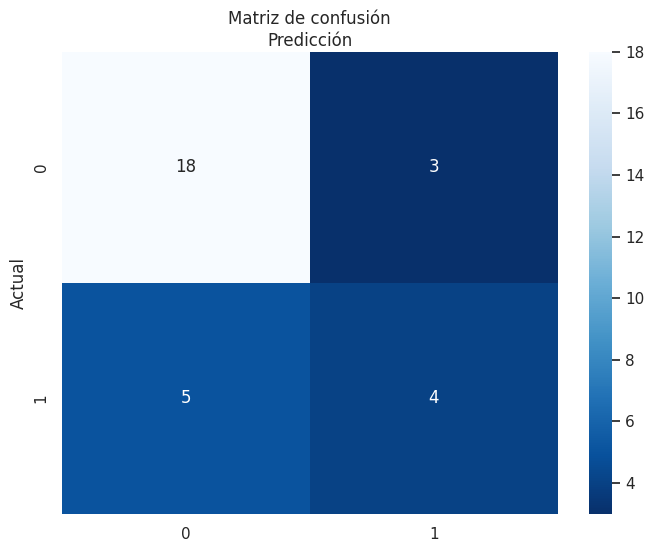

In [ ]:
metricas(y_test, y_pred_rounded)


De las métricas obtenidas en el cuadro anterior es posible concluir que el modelo es mejor para la predicción de videos no exitosos que de videos exitosos. El F1 score para la categoría 0 es 0.82, mientras que para la categoría 1 es apenas 0.50. El puntaje de precisión recibido para la categoría 1 fue de apenas 0.57. Esto quiere decir que de los resultados positivos identificados, solo el 57% eran realmente positivos. Esta precisión puede indicar que el modelo tiene una alta tasa de falsos positivos y puede estar realizando muchas predicciones erróneas de clase positiva.

Lo descrito anteriormente, puede verse de forma gráfica en la matriz de confusión. 

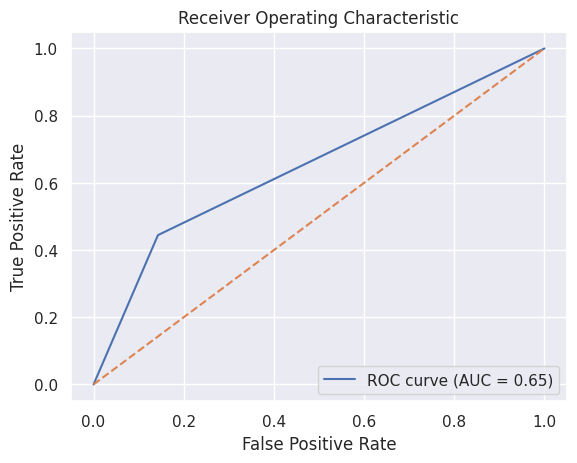

In [ ]:
AUC(y_test, y_pred_rounded)

Mientras más cercano esté el valor del AUC a 1, mejor será la capacidad del modelo para hacer predicciones correctas. Un AUC de 0.65 es razonable para el problema que se estudia. 

## Optimización de Hiperparámetros

Los hiperparámetros que se optimizarán son: max_depth, subsample, colsample_bytree, eta y n_estimators. Para esto se usa la librería Hyperopt de optimización de hiperparámetros. Usa el enfoque bayesiano para buscar eficientemente en el espacio de hiperparámetros, y utiliza algoritmos como el árbol de búsqueda parzen (TPE).

In [ ]:
# Definir espacio de búsqueda de hiperparámetros
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'eta': hp.uniform('eta',0.1, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 1)
}

In [ ]:
# Función objetivo para optimización
def objective(params):
    model = xgb.XGBClassifier(
        booster= 'gbtree',
        objective='binary:logistic',
        max_depth=int(params['max_depth']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        eta=params['eta'],
        n_estimators=int(params['n_estimators']),
        random_state=42
    )
    # Entrenar y evaluar el modelo
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': 'ok'}

In [ ]:

# Realizar la optimización de parámetros
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=1000,
    )

100%|██████████| 1000/1000 [02:34<00:00,  6.49trial/s, best loss: -0.9333333333333333]


Después de mil iteraciones para buscar los mejores hiperparámetros se obtienen los resultados que se muestran a continuación.

In [ ]:
best_params

{'colsample_bytree': 0.9062445677251313,
 'eta': 0.8761245109327598,
 'max_depth': 8.0,
 'n_estimators': 631.0,
 'subsample': 0.732581027653276}

Al usar estos parámetros para entrenar el modelo se tiene:

In [ ]:
# Entrenar el modelo con los mejores parámetros encontrados
final_model = xgb.XGBClassifier(
    booster='gbtree',
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    eta=best_params['eta'],
    eval_metric=['logloss','error','auc'],
    random_state=42
)
final_model.fit(X_train, y_train, eval_set=[(X_train, y_train), 
                    (X_test, y_test)])

[0]	validation_0-logloss:0.51242	validation_0-error:0.22857	validation_0-auc:0.82516	validation_1-logloss:0.59379	validation_1-error:0.33333	validation_1-auc:0.69841
[1]	validation_0-logloss:0.32663	validation_0-error:0.05714	validation_0-auc:0.97712	validation_1-logloss:0.58300	validation_1-error:0.30000	validation_1-auc:0.72487
[2]	validation_0-logloss:0.25642	validation_0-error:0.07143	validation_0-auc:0.99469	validation_1-logloss:0.59590	validation_1-error:0.26667	validation_1-auc:0.73545
[3]	validation_0-logloss:0.20720	validation_0-error:0.05714	validation_0-auc:0.99592	validation_1-logloss:0.54700	validation_1-error:0.23333	validation_1-auc:0.77513
[4]	validation_0-logloss:0.17073	validation_0-error:0.02857	validation_0-auc:0.99918	validation_1-logloss:0.49102	validation_1-error:0.23333	validation_1-auc:0.81746
[5]	validation_0-logloss:0.14938	validation_0-error:0.02857	validation_0-auc:0.99918	validation_1-logloss:0.49239	validation_1-error:0.23333	validation_1-auc:0.81746
[6]	

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9062445677251313, early_stopping_rounds=None,
              enable_categorical=False, eta=0.8761245109327598,
              eval_metric=['logloss', 'error', 'auc'], feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=631, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

En la iteración 631 se logra en los datos de entrenamiento un log loss de 0.03932, un error de 0 y un AUC de 1. Para los datos de testeo se llega a un log loss de 0.386, error de 0.06667 y AUC de 0.92063. En las gráficas a continuación se puede evidenciar esto.  Como es de esperarse las métricas del set de testeo son un poco inferiores a las de testeo. Aún con esto, las métricas obtenidas son buenas, y no habría evidencia de sobreajuste del modelo. 

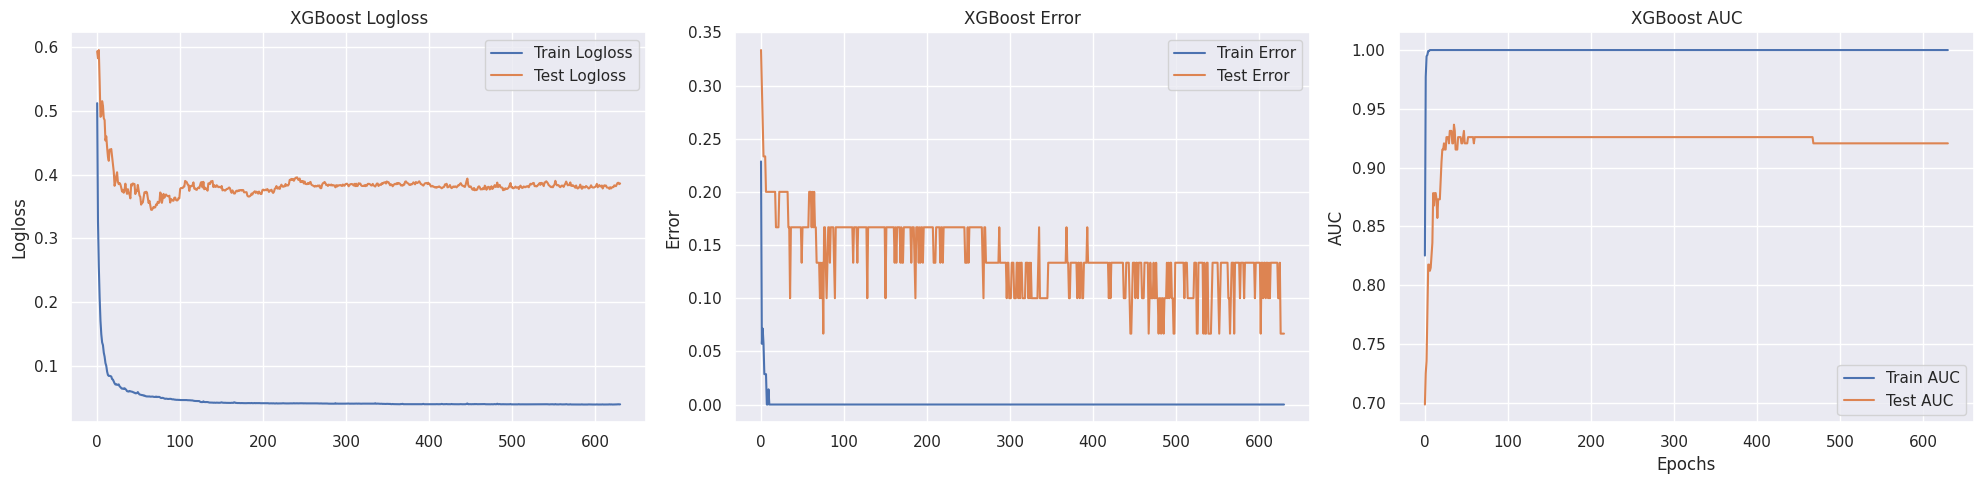

In [ ]:
results = final_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot logloss
ax1.plot(x_axis, results['validation_0']['logloss'], label='Train Logloss')
ax1.plot(x_axis, results['validation_1']['logloss'], label='Test Logloss')
ax1.legend()
ax1.set_ylabel('Logloss')
ax1.set_title('XGBoost Logloss')

# Plot Error
ax2.plot(x_axis, results['validation_0']['error'], label='Train Error')
ax2.plot(x_axis, results['validation_1']['error'], label='Test Error')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('XGBoost Error')

# Plot AUC
ax3.plot(x_axis, results['validation_0']['auc'], label='Train AUC')
ax3.plot(x_axis, results['validation_1']['auc'], label='Test AUC')
ax3.legend()
ax3.set_ylabel('AUC')
ax3.set_title('XGBoost AUC')

plt.xlabel('Epochs')

plt.tight_layout()
plt.show()

En estas gráficas se observa que el modelo converge rápidamente a métricas aceptables para los datos de entrenamiento. Sin embargo, esto no es evidenciable en el set de testeo. En los tres casos aquí graficados, se muestra una mejoría entre las métricas de la primera y la última iteración. Sin embargo, no se aprecia una mejoría en cada paso del proceso que justifique el aumento en la complejidad del modelo. Es decir, la complejidad del modelo no necesariamente se ve traducida en un mejor rendimiento. 

Viendo métricas adicionales, se tiene que:

Precision: 0.8181818181818182
Recall: 1.0
F1-score: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.82      1.00      0.90         9

    accuracy                           0.93        30
   macro avg       0.91      0.95      0.93        30
weighted avg       0.95      0.93      0.94        30

Confusion Matrix:


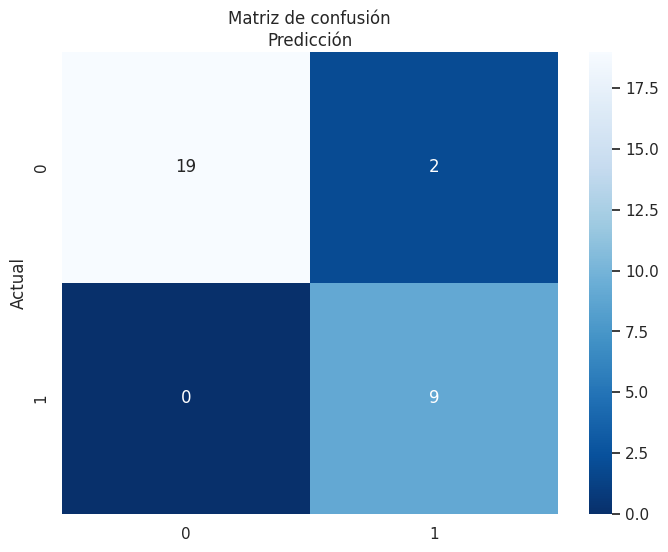

In [ ]:
y_pred = final_model.predict(X_test)
y_pred = np.round(y_pred)  # Redondea las predicciones a la clase más cercana (binario)

metricas(y_test,y_pred)

Al igual que con el primer modelo entrenado, es posible concluir este modelo es mejor para la predicción de videos no exitosos que de videos exitosos. El F1 score para la categoría 0 es 0.95, mientras que para la categoría 1 es 0.90. Sin embargo, este modelo tiene una métrica de accuracy en 0.93, y adecuados resultados en el F1 score de ambas categorías. Estos resultados indican una buena habilidad del modelo para capturar tantos los casos de videos exitosos como no exitosos.

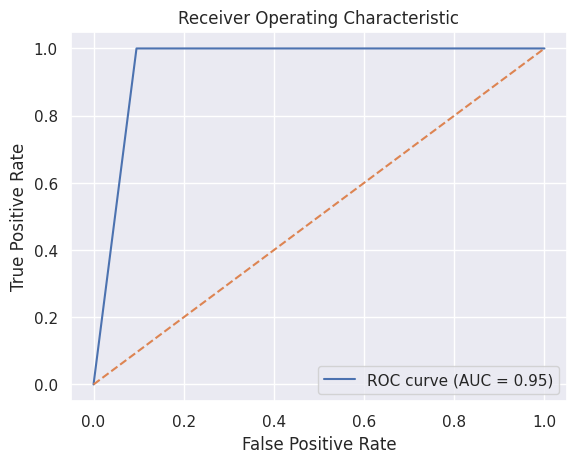

In [ ]:
AUC(y_test, y_pred)

En esta gráfica se evidencia un AUC de 0.95. 

### Optimización de max_depth y n_estimators

A modo de experimento, se continua con la optimización de max_depth y n_estimators, manteniendo el resto de los hiperparámetros constantes. Se toman estos dos parámetros al ser de importancia para la complejidad del modelo, y la relación sesgo-varianza. Se determinan los siguientes parámetros:

'subsample': 0.8
'colsample_bytree': 0.85
'eta': 0.1

Estos valores se definen buscando evitar el sobreajuste del modelo. 

In [ ]:
# Espacio de búsqueda de hiperparámetros
space2 = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 1)
}

In [ ]:
# Función objetivo para optimización
def objective2(params):
    model = xgb.XGBClassifier(
        booster= 'gbtree',
        objective='binary:logistic',
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        colsample_bytree = 0.85,
        eta=0.1,
        subsample=0.8,     
        random_state=42
    )
    # Entrenar y evaluar el modelo
    model.fit(X_train, y_train)
    y_pred3 = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred3)
    return {'loss': -accuracy, 'status': 'ok'}

In [ ]:
# Optimización de parámetros
best_params3 = fmin(
    fn=objective2,
    space=space2,
    algo=tpe.suggest,
    max_evals=1000,
    )

100%|██████████| 1000/1000 [03:11<00:00,  5.21trial/s, best loss: -0.8333333333333334]


In [ ]:
best_params3

{'max_depth': 7.0, 'n_estimators': 994.0}

In [ ]:
# Entrenar el modelo con los mejores parámetros encontrados
xgb_final_model = xgb.XGBClassifier(
    booster='gbtree',
    n_estimators=int(best_params3['n_estimators']),
    max_depth=int(best_params3['max_depth']),
    subsample=0.8,
    colsample_bytree=0.85,
    eta=0.1,
    eval_metric=['logloss','error','auc'],
    random_state=42
)
xgb_final_model.fit(X_train, y_train, eval_set=[(X_train, y_train), 
                    (X_test, y_test)])

[0]	validation_0-logloss:0.65466	validation_0-error:0.18571	validation_0-auc:0.83701	validation_1-logloss:0.66531	validation_1-error:0.23333	validation_1-auc:0.76984
[1]	validation_0-logloss:0.62927	validation_0-error:0.15714	validation_0-auc:0.92933	validation_1-logloss:0.65297	validation_1-error:0.30000	validation_1-auc:0.78571
[2]	validation_0-logloss:0.59583	validation_0-error:0.14286	validation_0-auc:0.96242	validation_1-logloss:0.62796	validation_1-error:0.23333	validation_1-auc:0.81217
[3]	validation_0-logloss:0.57542	validation_0-error:0.11429	validation_0-auc:0.97386	validation_1-logloss:0.61772	validation_1-error:0.26667	validation_1-auc:0.80952
[4]	validation_0-logloss:0.55244	validation_0-error:0.08571	validation_0-auc:0.97794	validation_1-logloss:0.60724	validation_1-error:0.23333	validation_1-auc:0.87302
[5]	validation_0-logloss:0.52640	validation_0-error:0.10000	validation_0-auc:0.97631	validation_1-logloss:0.58581	validation_1-error:0.23333	validation_1-auc:0.86243
[6]	

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1,
              eval_metric=['logloss', 'error', 'auc'], feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=994, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

En la última iteración del modelo se logra un logloos de 0.04255, error de 0 y AUC de 1 para el set de entrenamiento. Por el lado del set de testeo se alcanza un logloss de 0.43403, error de 0.16667 y AUC de 0.87831.

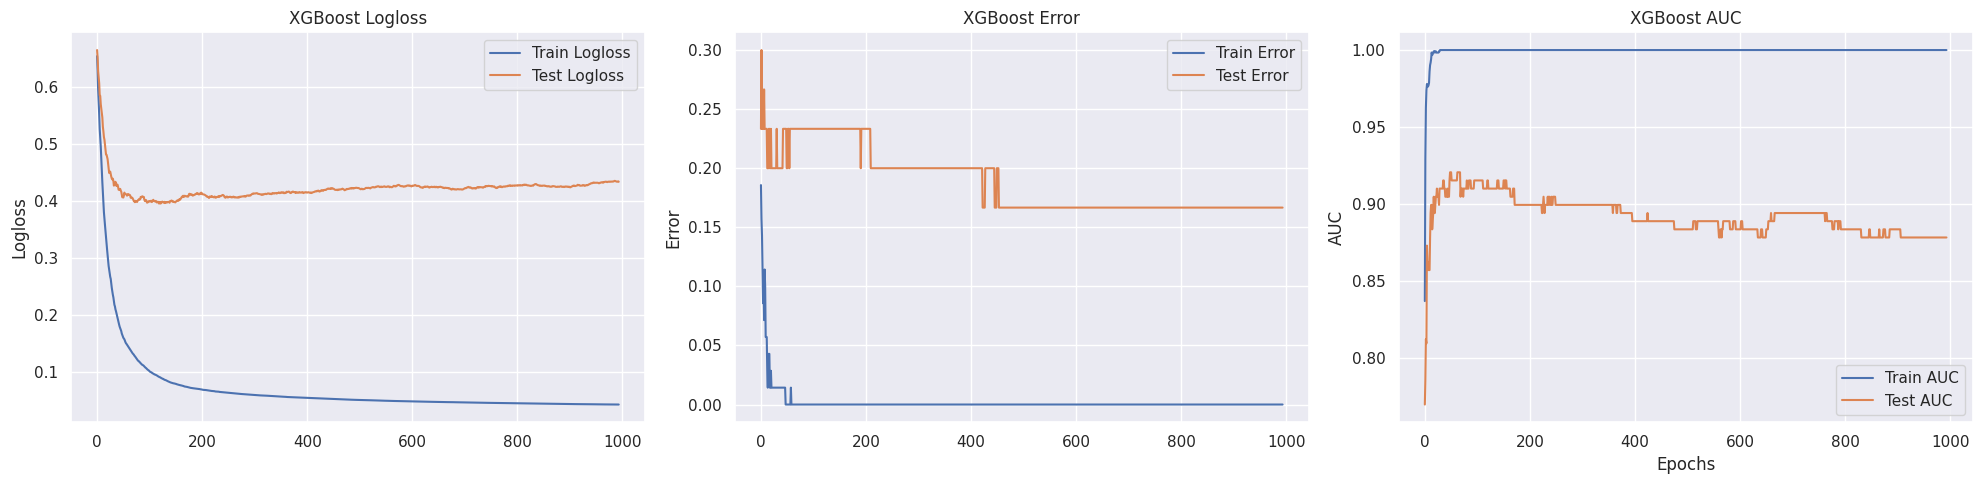

In [ ]:
results2 = xgb_final_model.evals_result()
epochs2 = len(results2['validation_0']['logloss'])
x_axis = range(0, epochs2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot logloss
ax1.plot(x_axis, results2['validation_0']['logloss'], label='Train Logloss')
ax1.plot(x_axis, results2['validation_1']['logloss'], label='Test Logloss')
ax1.legend()
ax1.set_ylabel('Logloss')
ax1.set_title('XGBoost Logloss')

# Plot Error
ax2.plot(x_axis, results2['validation_0']['error'], label='Train Error')
ax2.plot(x_axis, results2['validation_1']['error'], label='Test Error')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('XGBoost Error')

# Plot AUC
ax3.plot(x_axis, results2['validation_0']['auc'], label='Train AUC')
ax3.plot(x_axis, results2['validation_1']['auc'], label='Test AUC')
ax3.legend()
ax3.set_ylabel('AUC')
ax3.set_title('XGBoost AUC')

plt.xlabel('Epochs')

plt.tight_layout()
plt.show()

Precision: 0.7
Recall: 0.7777777777777778
F1-score: 0.7368421052631577
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.70      0.78      0.74         9

    accuracy                           0.83        30
   macro avg       0.80      0.82      0.81        30
weighted avg       0.84      0.83      0.84        30

Confusion Matrix:


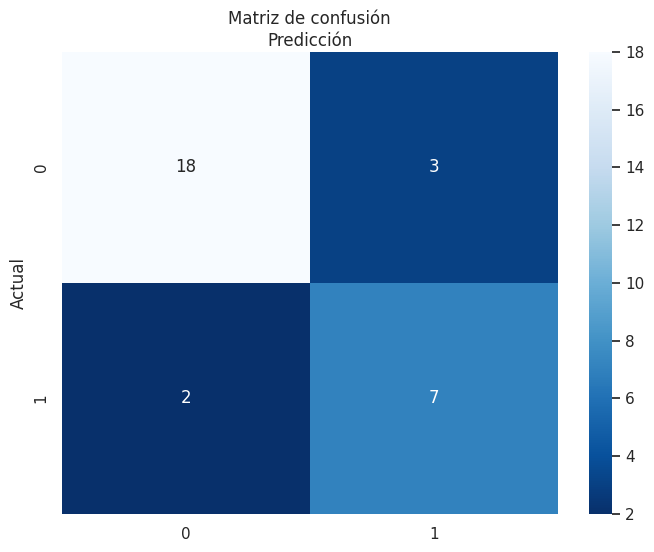

In [ ]:
y_pred_n = xgb_final_model.predict(X_test)
y_pred_n = np.round(y_pred_n)  # Redondea las predicciones a la clase más cercana (binario)

# Calcular las métricas
metricas(y_test, y_pred_n)

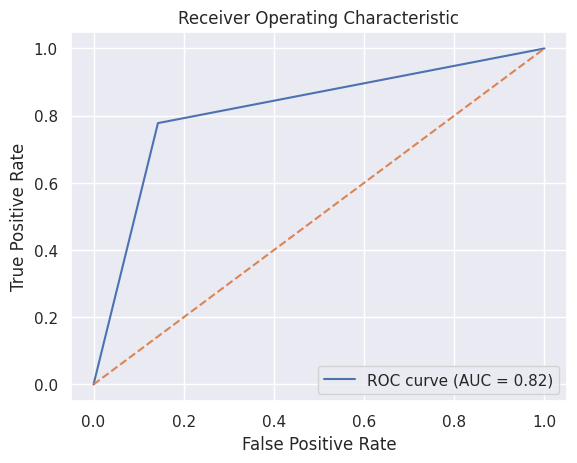

In [ ]:
AUC(y_test, y_pred_n)

## Optimización de Hiperparámetros con Cross-Validation

Con cross-validation

In [ ]:
# Definir espacio de búsqueda de hiperparámetros
spaceCV = {
    'max_depth': [int(i) for i in range(1,10)],
    'subsample': [i for i in np.arange(0.1,1,0.1)],
    'colsample_bytree': [i for i in np.arange(0.1,1,1)],
    'eta': [i for i in np.arange(0.01,0.1,0.1)]
}

In [ ]:
# Crear un objeto XGBoost Classifier
xgb_model = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic')

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=spaceCV, cv=5, scoring='accuracy')

# Realizar la búsqueda de hiperparámetros y validación cruzada
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_paramsCV = grid_search.best_params_

# Entrenar el modelo final con los mejores hiperparámetros encontrados
final_modelCV = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic', **best_paramsCV)
final_modelCV.fit(X_train, y_train)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
best_paramsCV

{'colsample_bytree': 0.1, 'eta': 0.01, 'max_depth': 2, 'subsample': 0.4}

Testing accuracy  test= 0.7666666666666667
Precision: 0.6666666666666666
Recall: 0.4444444444444444
F1-score: 0.5333333333333333
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.67      0.44      0.53         9

    accuracy                           0.77        30
   macro avg       0.73      0.67      0.69        30
weighted avg       0.75      0.77      0.75        30

Confusion Matrix:


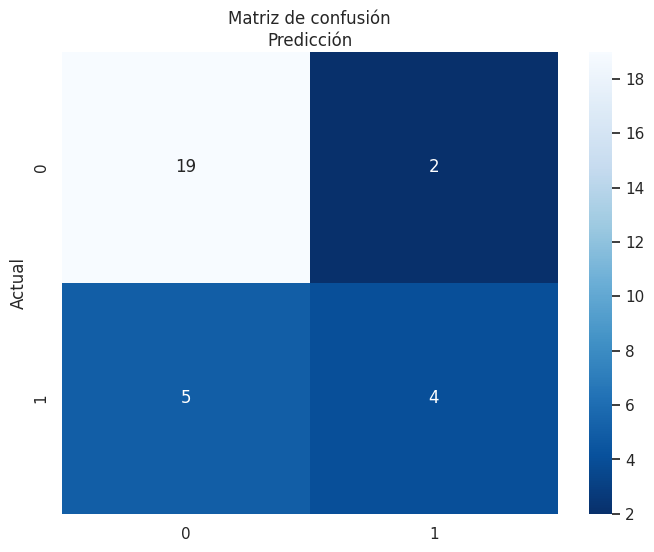

In [ ]:
y_predCV = final_modelCV.predict(X_test)
y_predCV = np.round(y_predCV)  # Redondea las predicciones a la clase más cercana (binario)

print("Testing accuracy  test=", accuracy_score(y_test, y_predCV))

metricas(y_test, y_predCV)


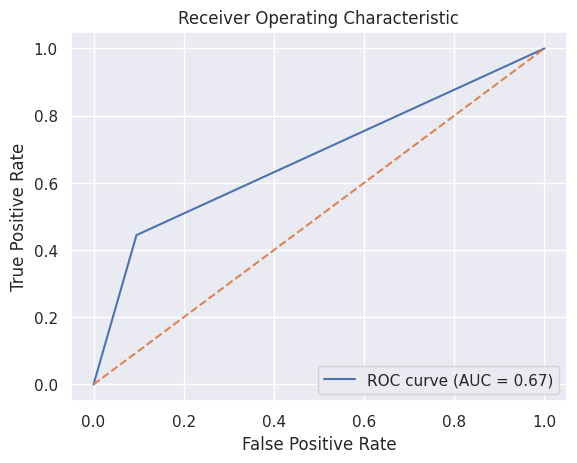

In [ ]:
AUC(y_test, y_predCV)

Otra optimización

In [ ]:
# Definir espacio de búsqueda de hiperparámetros
spaceCV2 = {
    'max_depth': [int(i) for i in range(2,10)],
    'subsample': [i for i in np.arange(0.1,1,0.1)],
    'colsample_bytree': [i for i in np.arange(0.1,1,1)],
    'eta': [i for i in np.arange(0.04,0.3,0.04)]
}

In [ ]:
# Crear un objeto XGBoost Classifier
xgb_model2 = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic')

# Crear el objeto GridSearchCV
grid_search2 = GridSearchCV(estimator=xgb_model2, param_grid=spaceCV2, cv=5, scoring='accuracy')

# Realizar la búsqueda de hiperparámetros y validación cruzada
grid_search2.fit(X_train, y_train)

# Obtener los mejores hiperparámetros encontrados
best_paramsCV2 = grid_search2.best_params_

# Entrenar el modelo final con los mejores hiperparámetros encontrados
final_modelCV2 = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic', **best_paramsCV2)
final_modelCV2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.24000000000000002,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

In [ ]:
best_paramsCV2

{'colsample_bytree': 0.1,
 'eta': 0.24000000000000002,
 'max_depth': 5,
 'subsample': 0.9}

Testing accuracy  test= 0.8333333333333334
Precision: 0.8333333333333334
Recall: 0.5555555555555556
F1-score: 0.6666666666666667
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        21
           1       0.83      0.56      0.67         9

    accuracy                           0.83        30
   macro avg       0.83      0.75      0.78        30
weighted avg       0.83      0.83      0.82        30

Confusion Matrix:


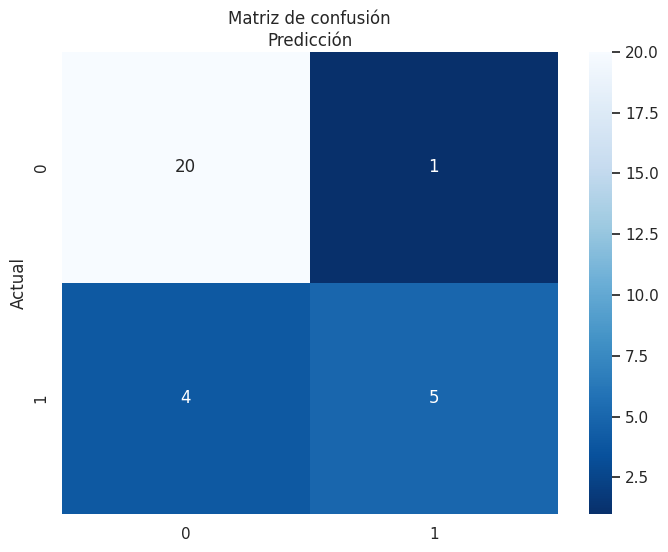

In [ ]:
y_predCV2 = final_modelCV2.predict(X_test)
y_predCV2 = np.round(y_predCV2)  # Redondea las predicciones a la clase más cercana (binario)

print("Testing accuracy  test=", accuracy_score(y_test, y_predCV2))

metricas(y_test,y_predCV2)

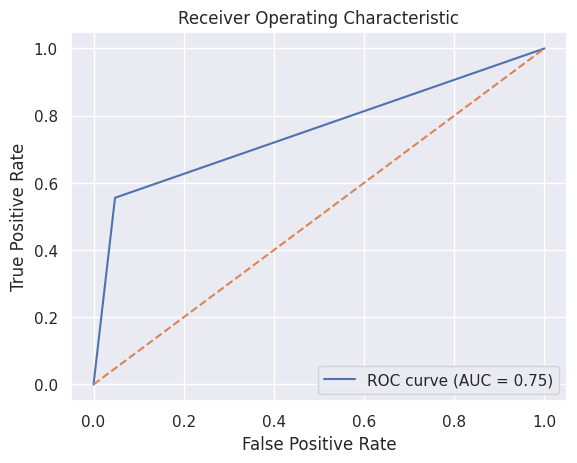

In [ ]:
AUC(y_test, y_predCV2)

In [37]:
params_nw = {'max_depth': 6, 
            'n_estimators': 300, 
            'objective': 'binary:logistic', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'eval_metric': ['logloss','error','auc'],
            'seed': 42}     

mnw = XGBClassifier(**params_nw)

mnw.fit(X_train, y_train,eval_set=[(X_train, y_train), 
                    (X_test, y_test)])

[0]	validation_0-logloss:0.65466	validation_0-error:0.18571	validation_0-auc:0.83701	validation_1-logloss:0.66531	validation_1-error:0.23333	validation_1-auc:0.76984
[1]	validation_0-logloss:0.62927	validation_0-error:0.15714	validation_0-auc:0.92933	validation_1-logloss:0.65297	validation_1-error:0.30000	validation_1-auc:0.78571
[2]	validation_0-logloss:0.59583	validation_0-error:0.14286	validation_0-auc:0.96242	validation_1-logloss:0.62796	validation_1-error:0.23333	validation_1-auc:0.81217
[3]	validation_0-logloss:0.57542	validation_0-error:0.11429	validation_0-auc:0.97386	validation_1-logloss:0.61772	validation_1-error:0.26667	validation_1-auc:0.80952
[4]	validation_0-logloss:0.55244	validation_0-error:0.08571	validation_0-auc:0.97794	validation_1-logloss:0.60724	validation_1-error:0.23333	validation_1-auc:0.87302
[5]	validation_0-logloss:0.52640	validation_0-error:0.10000	validation_0-auc:0.97631	validation_1-logloss:0.58581	validation_1-error:0.23333	validation_1-auc:0.86243
[6]	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['logloss', 'error', 'auc'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

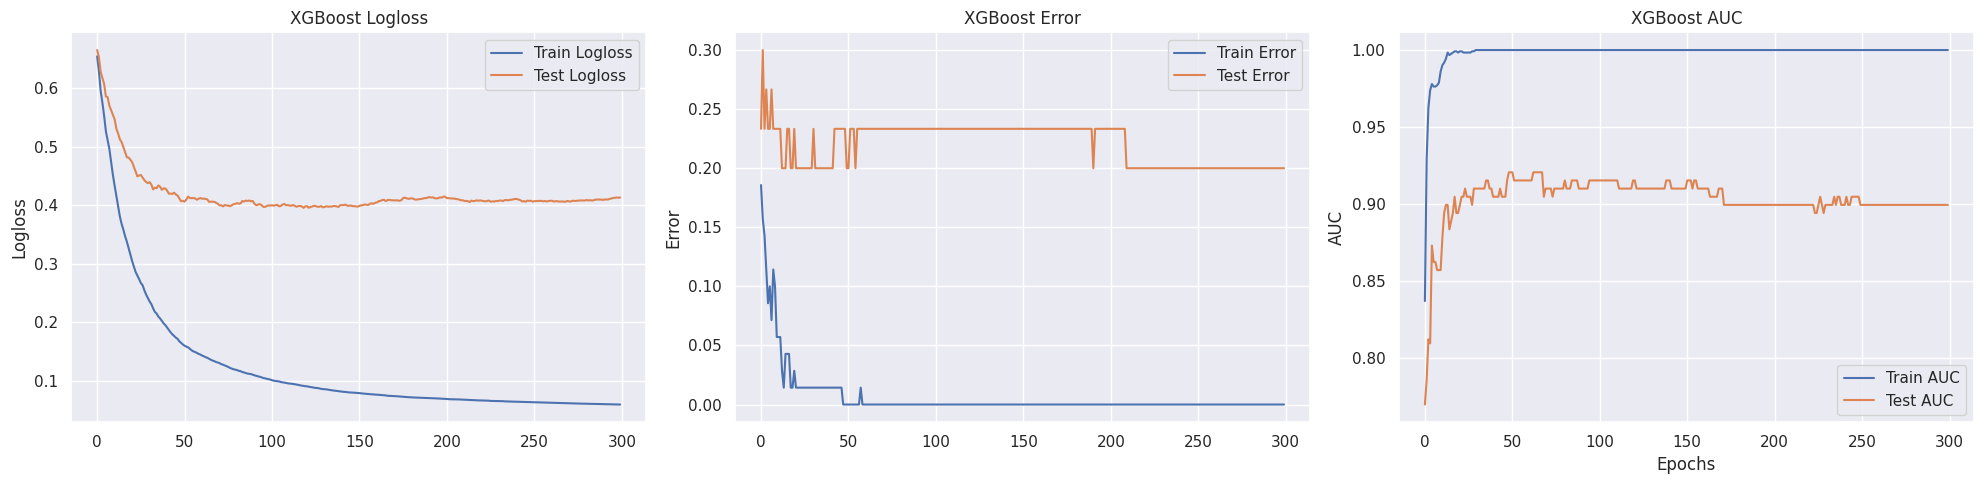

In [38]:
resultsCV = mnw.evals_result()
epochsCV = len(resultsCV['validation_0']['logloss'])
x_axis = range(0, epochsCV)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot logloss
ax1.plot(x_axis, resultsCV['validation_0']['logloss'], label='Train Logloss')
ax1.plot(x_axis, resultsCV['validation_1']['logloss'], label='Test Logloss')
ax1.legend()
ax1.set_ylabel('Logloss')
ax1.set_title('XGBoost Logloss')

# Plot Error
ax2.plot(x_axis, resultsCV['validation_0']['error'], label='Train Error')
ax2.plot(x_axis, resultsCV['validation_1']['error'], label='Test Error')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('XGBoost Error')

# Plot AUC
ax3.plot(x_axis, resultsCV['validation_0']['auc'], label='Train AUC')
ax3.plot(x_axis, resultsCV['validation_1']['auc'], label='Test AUC')
ax3.legend()
ax3.set_ylabel('AUC')
ax3.set_title('XGBoost AUC')

plt.xlabel('Epochs')

plt.tight_layout()
plt.show()

Incluyendo los parámetros de regularización.

In [39]:
params_grid = {
    'max_depth': [int(i) for i in range(2,10)],
    'subsample': [i for i in np.arange(0.1,1,0.1)],
    'colsample_bytree': [i for i in np.arange(0.5,1,1)],
    'learning_rate': [i for i in np.arange(0.04,0.3,0.04)],
    'gamma': [i for i in np.arange(0.0,1,0.1)],
    'reg_alpha': [int(i) for i in range(0,10)]
}

search_nw = RandomizedSearchCV(mnw, params_grid, cv = 5) # 5 fold cross validation
search_nw.fit(X_train, y_train)

# best parameters
print(search_nw.best_params_); print(search_sk.best_score_)

{'subsample': 0.9, 'reg_alpha': 1, 'max_depth': 4, 'learning_rate': 0.08, 'gamma': 0.4, 'colsample_bytree': 0.5}
0.7000000000000001


In [ ]:
params_new = {
    'booster': 'gbtree', 
    'objective': 'binary:logistic', 
    'subsample': 0.8, 
    'colsample_bytree': 0.5, 
    'eta': 0.28, 
    'max_depth': 5, 
    'gamma': 0.6,
    'reg_alpha': 1,
    'eval_metric': ['logloss','error','auc'],
    'seed': 42} 

final_modelCV3 = xgb.XGBClassifier(**params_new)
final_modelCV3.fit(X_train, y_train,eval_set=[(X_train, y_train), 
                    (X_test, y_test)])

[0]	validation_0-logloss:0.62176	validation_0-error:0.24286	validation_0-auc:0.78676	validation_1-logloss:0.63765	validation_1-error:0.23333	validation_1-auc:0.71164
[1]	validation_0-logloss:0.57033	validation_0-error:0.22857	validation_0-auc:0.88358	validation_1-logloss:0.62615	validation_1-error:0.26667	validation_1-auc:0.75132
[2]	validation_0-logloss:0.53419	validation_0-error:0.12857	validation_0-auc:0.93178	validation_1-logloss:0.61128	validation_1-error:0.26667	validation_1-auc:0.80952
[3]	validation_0-logloss:0.52087	validation_0-error:0.12857	validation_0-auc:0.93627	validation_1-logloss:0.60462	validation_1-error:0.26667	validation_1-auc:0.79365
[4]	validation_0-logloss:0.49098	validation_0-error:0.11429	validation_0-auc:0.95139	validation_1-logloss:0.58664	validation_1-error:0.26667	validation_1-auc:0.81481
[5]	validation_0-logloss:0.45870	validation_0-error:0.10000	validation_0-auc:0.96283	validation_1-logloss:0.55446	validation_1-error:0.26667	validation_1-auc:0.81481
[6]	

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eta=0.28,
              eval_metric=['logloss', 'error', 'auc'], feature_types=None,
              gamma=0.6, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

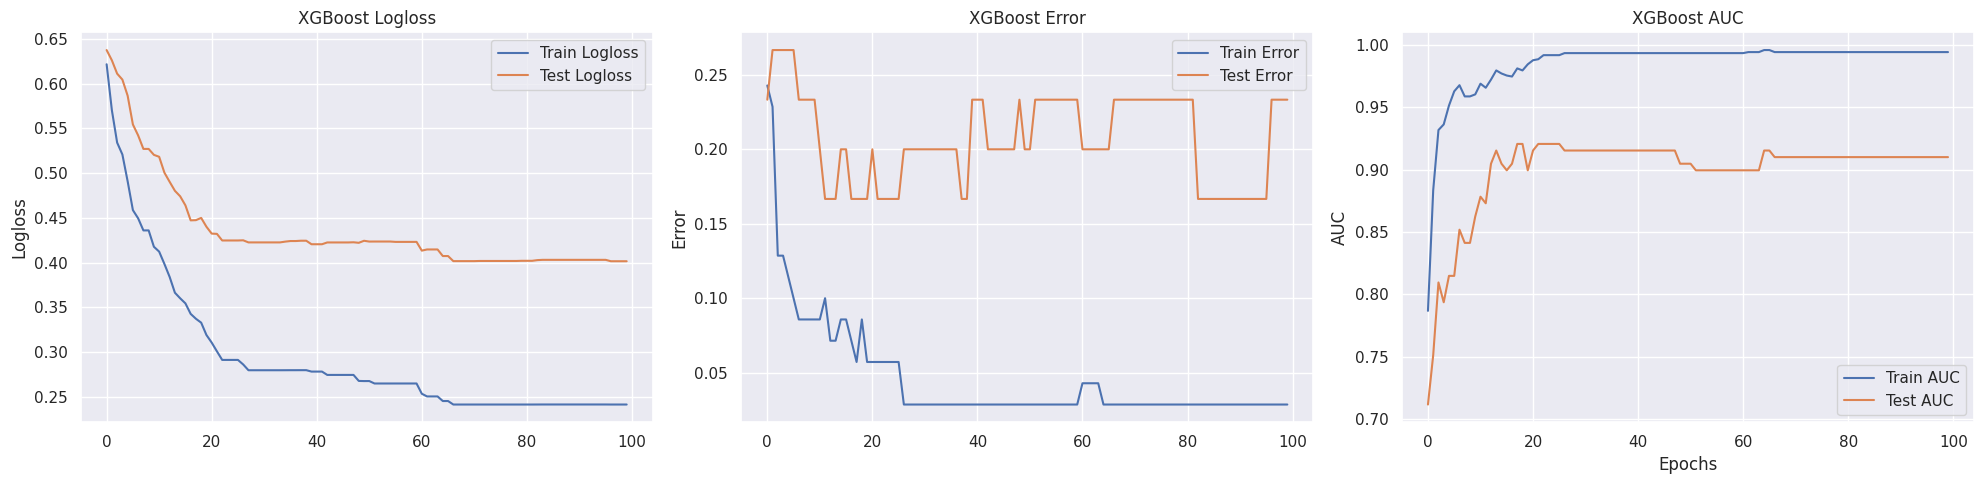

In [ ]:
resultsCV3 = final_modelCV3.evals_result()
epochsCV3 = len(resultsCV3['validation_0']['logloss'])
x_axis = range(0, epochsCV3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot logloss
ax1.plot(x_axis, resultsCV3['validation_0']['logloss'], label='Train Logloss')
ax1.plot(x_axis, resultsCV3['validation_1']['logloss'], label='Test Logloss')
ax1.legend()
ax1.set_ylabel('Logloss')
ax1.set_title('XGBoost Logloss')

# Plot Error
ax2.plot(x_axis, resultsCV3['validation_0']['error'], label='Train Error')
ax2.plot(x_axis, resultsCV3['validation_1']['error'], label='Test Error')
ax2.legend()
ax2.set_ylabel('Error')
ax2.set_title('XGBoost Error')

# Plot AUC
ax3.plot(x_axis, resultsCV3['validation_0']['auc'], label='Train AUC')
ax3.plot(x_axis, resultsCV3['validation_1']['auc'], label='Test AUC')
ax3.legend()
ax3.set_ylabel('AUC')
ax3.set_title('XGBoost AUC')

plt.xlabel('Epochs')

plt.tight_layout()
plt.show()

Testing accuracy  test= 0.7666666666666667
Precision: 0.6666666666666666
Recall: 0.4444444444444444
F1-score: 0.5333333333333333
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.67      0.44      0.53         9

    accuracy                           0.77        30
   macro avg       0.73      0.67      0.69        30
weighted avg       0.75      0.77      0.75        30

Confusion Matrix:


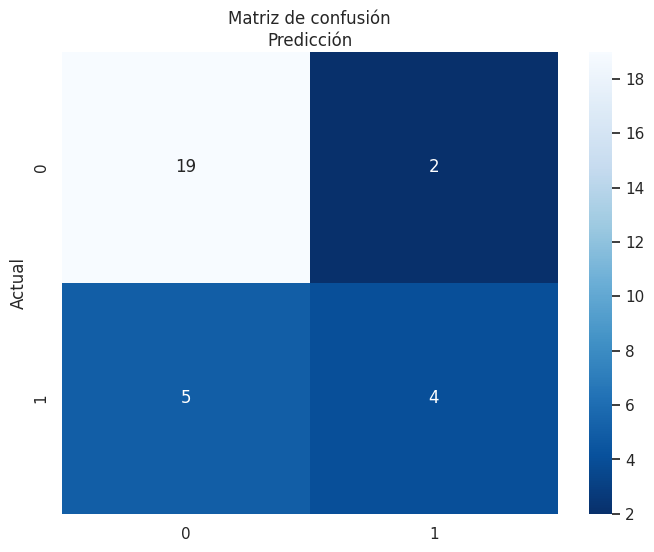

In [ ]:
y_predCV3 = final_modelCV3.predict(X_test)
y_predCV3 = np.round(y_predCV3)  # Redondea las predicciones a la clase más cercana (binario)

print("Testing accuracy  test=", accuracy_score(y_test, y_predCV3))

metricas(y_test,y_predCV3)

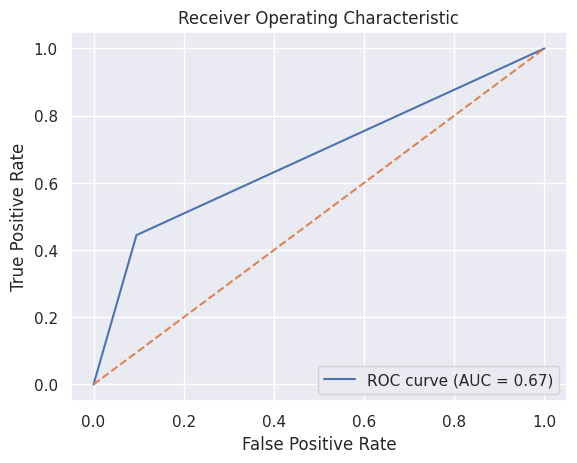

In [ ]:
AUC(y_test,y_predCV3)

## Importancia de las Variables en el Modelo

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

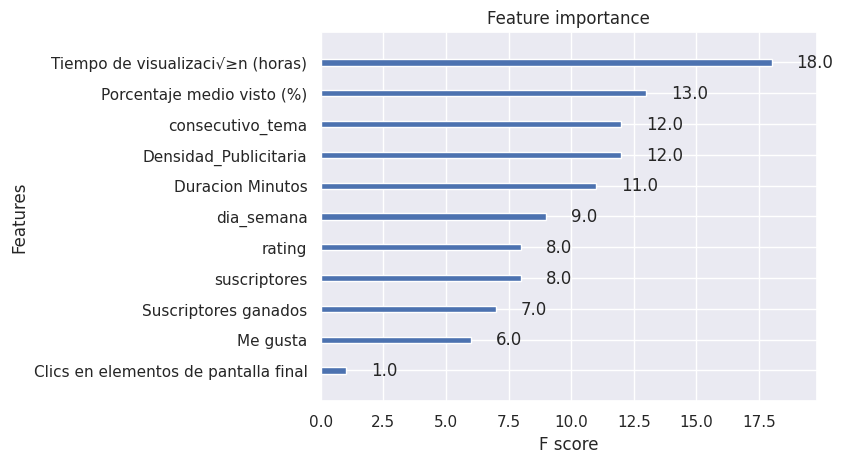

In [ ]:
xgb.plot_importance(final_modelCV)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

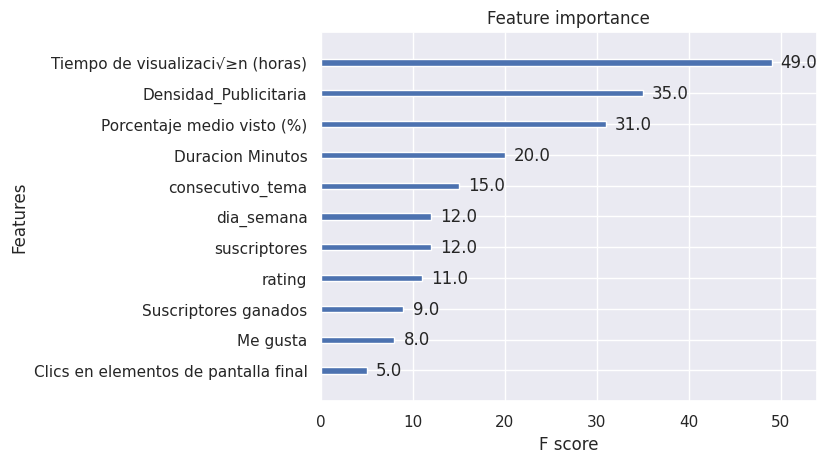

In [ ]:
xgb.plot_importance(final_modelCV2)

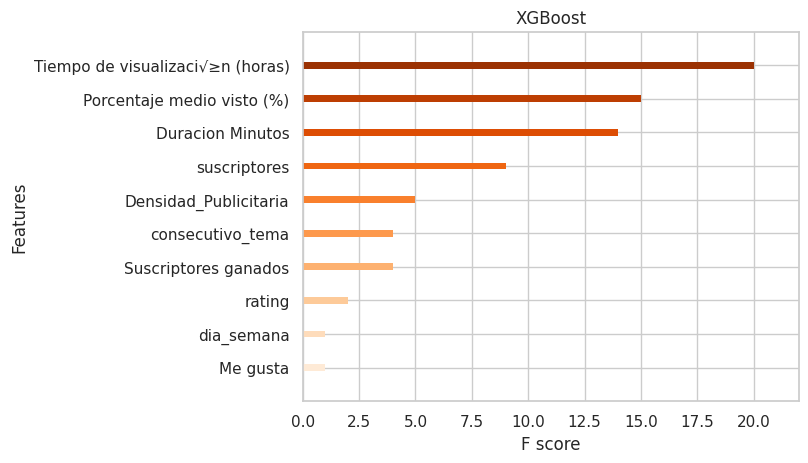

In [ ]:
sns.set_style("whitegrid")

colors = sns.color_palette("Oranges", n_colors=10)
xgb.plot_importance(final_modelCV3, color=colors, linewidth=0, title = 'XGBoost', show_values = False);

In [ ]:
importancia =  final_modelCV3.feature_importances_
impvariables=pd.DataFrame()
impvariables['Variable']= final_modelCV3.feature_names_in_
impvariables['Importancia'] = importancia
impvariables.sort_values('Importancia', ascending=False)

impvariables

,Variable,Importancia
0,Suscriptores ganados,0.071318
1,Tiempo de visualizaci√≥n (horas),0.178269
2,Me gusta,0.068609
3,Clics en teaser de tarjeta,0.000000
4,Tarjetas mostradas,0.000000
5,Clics en elementos de pantalla final,0.000000
6,suscriptores,0.147048
7,Densidad_Publicitaria,0.107341
8,Duracion Minutos,0.077428
9,Comentarios a√±adidos,0.000000


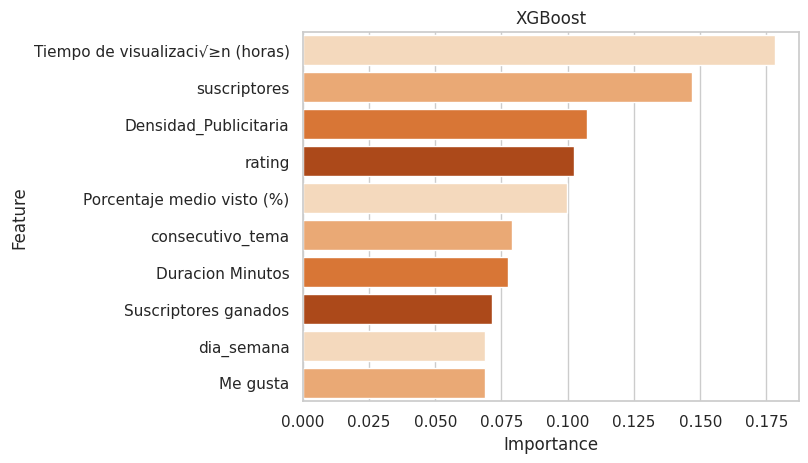

In [ ]:
# Establecer estilo con fondo blanco
sns.set_style("whitegrid")

impvariables = impvariables[impvariables.Importancia > 0]
impvariables.sort_values('Importancia', ascending = False, inplace=True)

colors = sns.color_palette("Oranges", n_colors=4)

sns.barplot(x='Importancia', y = 'Variable', data = impvariables, palette=colors)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('XGBoost');

# Feature Selection with XGBoost Feature Importance Scores

In [ ]:
import numpy as np
from numpy import sort
import pandas as pd
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
# Fit model using each importance as a threshold
thresholds = sort(final_modelCV3.feature_importances_)
for thresh in thresholds:
 # select features using threshold
 selection = SelectFromModel(final_modelCV3, threshold=thresh, prefit=True)
 select_X_train = selection.transform(X_train)
 # train model
 selection_model = XGBClassifier()
 selection_model.fit(select_X_train, y_train)
 # eval model
 select_X_test = selection.transform(X_test)
 y_pred = selection_model.predict(select_X_test)
 predictions = [round(value) for value in y_pred]
 accuracy = accuracy_score(y_test, predictions)
 print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=15, Accuracy: 73.33%
Thresh=0.000, n=15, Accuracy: 73.33%
Thresh=0.000, n=15, Accuracy: 73.33%
Thresh=0.000, n=15, Accuracy: 73.33%
Thresh=0.000, n=15, Accuracy: 73.33%
Thresh=0.069, n=10, Accuracy: 73.33%
Thresh=0.069, n=9, Accuracy: 73.33%
Thresh=0.071, n=8, Accuracy: 76.67%
Thresh=0.077, n=7, Accuracy: 73.33%
Thresh=0.079, n=6, Accuracy: 73.33%
Thresh=0.100, n=5, Accuracy: 76.67%
Thresh=0.102, n=4, Accuracy: 73.33%
Thresh=0.107, n=3, Accuracy: 66.67%
Thresh=0.147, n=2, Accuracy: 76.67%
Thresh=0.178, n=1, Accuracy: 70.00%


In [ ]:
best_accuracy = 0.0
best_features = None
feature_names = X_train.columns

thresholds = sorted(final_modelCV3.feature_importances_)
for thresh in thresholds:
    selection = SelectFromModel(final_modelCV3, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_features = select_X_train
    
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

best_feature_names = feature_names[selection.get_support()]
print("Best Accuracy: %.2f%%" % (best_accuracy*100.0))
print("Best Features: ", best_feature_names)

Thresh=0.000, n=15, Accuracy: 73.33%
Thresh=0.000, n=15, Accuracy: 73.33%
Thresh=0.000, n=15, Accuracy: 73.33%
Thresh=0.000, n=15, Accuracy: 73.33%
Thresh=0.000, n=15, Accuracy: 73.33%
Thresh=0.069, n=10, Accuracy: 73.33%
Thresh=0.069, n=9, Accuracy: 73.33%
Thresh=0.071, n=8, Accuracy: 76.67%
Thresh=0.077, n=7, Accuracy: 73.33%
Thresh=0.079, n=6, Accuracy: 73.33%
Thresh=0.100, n=5, Accuracy: 76.67%
Thresh=0.102, n=4, Accuracy: 73.33%
Thresh=0.107, n=3, Accuracy: 66.67%
Thresh=0.147, n=2, Accuracy: 76.67%
Thresh=0.178, n=1, Accuracy: 70.00%
Best Accuracy: 76.67%
Best Features:  Index(['Tiempo de visualizaci√≥n (horas)'], dtype='object')


In [ ]:
feature_names = X_train.columns

# Fit model using each importance as a threshold
thresholds = np.sort(final_modelCV3.feature_importances_)

for thresh in thresholds:
    # Select features using threshold
    selection = SelectFromModel(final_modelCV3, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    
    # Train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    # Evaluate model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    
    # Obtener los nombres de las características seleccionadas
    selected_feature_indices = selection.get_support(indices=True)
    selected_feature_names = feature_names[selected_feature_indices]
    
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print("Selected Features: ", selected_feature_names)


Thresh=0.000, n=15, Accuracy: 73.33%
Selected Features:  Index(['Suscriptores ganados', 'Tiempo de visualizaci√≥n (horas)', 'Me gusta',
       'Clics en teaser de tarjeta', 'Tarjetas mostradas',
       'Clics en elementos de pantalla final', 'suscriptores',
       'Densidad_Publicitaria', 'Duracion Minutos', 'Comentarios a√±adidos',
       'Porcentaje medio visto (%)', 'rating', 'dia_semana',
       'consecutivo_tema', 'No me gusta'],
      dtype='object')
Thresh=0.000, n=15, Accuracy: 73.33%
Selected Features:  Index(['Suscriptores ganados', 'Tiempo de visualizaci√≥n (horas)', 'Me gusta',
       'Clics en teaser de tarjeta', 'Tarjetas mostradas',
       'Clics en elementos de pantalla final', 'suscriptores',
       'Densidad_Publicitaria', 'Duracion Minutos', 'Comentarios a√±adidos',
       'Porcentaje medio visto (%)', 'rating', 'dia_semana',
       'consecutivo_tema', 'No me gusta'],
      dtype='object')
Thresh=0.000, n=15, Accuracy: 73.33%
Selected Features:  Index(['Suscriptores 

In [ ]:
X_train_best=X_train.loc[:,['Suscriptores ganados', 'Tiempo de visualizaci√≥n (horas)', 'Me gusta',
       'suscriptores', 'Porcentaje medio visto (%)', 'RPM (USD)']]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['RPM (USD)'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [ ]:
X_test_best=X_test.loc[:,['Suscriptores ganados', 'Tiempo de visualizaci√≥n (horas)', 'Me gusta',
       'suscriptores', 'Porcentaje medio visto (%)', 'RPM (USD)']]

In [ ]:
# Train model
selection_model = XGBClassifier()
best_final_modelCV = selection_model.fit(X_train_best, y_train)
best_final_modelCV

In [ ]:
xgb.plot_importance(best_final_modelCV)

In [ ]:
# Establecer estilo con fondo blanco
# sns.set_style("whitegrid")

# colors = sns.color_palette("Oranges", n_colors=10)

# sns.barplot(x='Importancia', y = 'Variable', data = impvariables, palette=colors)
# plt.ylabel('Feature')
# plt.xlabel('Importance')
# plt.title('Random Forest');

In [ ]:
print(best_final_modelCV.feature_importances_)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve

# Calcular la curva ROC
roc_curve = plot_roc_curve(best_final_modelCV, X_test_best, y_test)

# Graficar la curva ROC
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guessing')  # Línea de referencia para clasificación aleatoria
roc_curve.plot()
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=af42914d-1d55-41f0-8851-adb5c602e38b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>